In [52]:
import torch
import math
from torch.utils import data
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch import nn
import numpy as np
from scipy.sparse import coo_matrix

## Data generation

In [53]:
def double_moons(data_size, shuffle=True, nf=2, noise_std=0, input_ch=None):

    data2d = torch.zeros(data_size, 2, 1)
    label = torch.zeros(data_size, 1)

    for i in range(int(data_size / 4)):
        theta = torch.tensor(i / int(data_size / 4) * 3.14)

        label[i, :] = 0
        data2d[i, :, :] = torch.tensor(
            [[torch.cos(theta) + 0.3*(torch.rand(1)-0.5)], [torch.sin(theta) + 0.3*(torch.rand(1)-0.5)]])

        label[i+int(data_size / 4), :] = 1
        data2d[i+int(data_size / 4), :, :] = torch.tensor(
            [[torch.ones(1) - torch.cos(theta) + 0.3*(torch.rand(1)-0.5)],
             [torch.ones(1)*0.5 - torch.sin(theta) + 0.3*(torch.rand(1)-0.5)]])

        label[i + int(data_size / 2), :] = 0
        data2d[i + int(data_size / 2), :, :] = torch.tensor(
            [[torch.cos(theta) + 0.3 * (torch.rand(1) - 0.5) + 2*torch.ones(1)],
             [torch.sin(theta) + 0.3 * (torch.rand(1) - 0.5)]])

        label[i + int(data_size * 3 / 4), :] = 1
        data2d[i + int(data_size * 3 / 4), :, :] = torch.tensor(
            [[torch.ones(1) - torch.cos(theta) + 0.3 * (torch.rand(1) - 0.5) + 2*torch.ones(1)],
             [torch.ones(1) * 0.5 - torch.sin(theta) + 0.3 * (torch.rand(1) - 0.5)]])
    
    if noise_std:
        for i in range(2):
            data2d[:, i, 0] = data2d[:, i, 0] + noise_std*torch.randn(data_size)
    
    if shuffle:
        data2d, label = _data_shuffle(data2d, label)

    if nf != 2:
        data2d = _data_extension(data2d, nf, input_ch)
    
    domain = [-2, 5, -1, 2]
    return data2d, label, domain

In [54]:
data_size = 8000
train_data_size = 4000
test_data_size = data_size - train_data_size
nf=2
data_gen = double_moons

In [55]:
def _data_shuffle(data2d, label):
    data_size = data2d.shape[0]
    randindex = torch.randperm(data_size)
    data2d = data2d[randindex, :, :]
    label = label[randindex, :]
    return data2d, label
def _data_extension(data2d, nf, input_ch=None):
    if nf < 2:
        print("Dimension not valid")
        return
    elif nf % 2 == 1:
        print("Using odd dimension nf")
    data_size = data2d.shape[0]
    if input_ch is not None:
        # input_ch is a list of two elements. The elements indicate where the data enters.
        idx_x = input_ch[0]
        idx_y = input_ch[1]
    else:
        idx_x = 0
        idx_y = nf-1
    data2d = torch.cat((torch.zeros(data_size, idx_x-0, 1),
                        data2d[:, 0:1, :],
                        torch.zeros(data_size, idx_y-idx_x-1, 1),
                        data2d[:, 1:2, :],
                        torch.zeros(data_size, nf-1-idx_y, 1)), 1)
    return data2d

In [56]:
data2d, labels, domain = data_gen(data_size,nf=2)

In [57]:
class Dataset(data.Dataset):

    def __len__(self):
        return len(self.list_ids)

    def __init__(self, list_ids, data_in, labels):
        self.list_ids = list_ids
        self.data = data_in
        self.labels = labels

    def __getitem__(self, index):

        idx = self.list_ids[index]

        x = self.data[idx, :, :]
        y = self.labels[idx, :]

        return x, y

partition = {'train': range(0, data_size, 2),
             'test': range(1, data_size, 2)}
training_set = Dataset(partition['train'], data2d, labels)


In [58]:
training_generator = data.DataLoader(training_set, batch_size=125, shuffle=True)

## Integrator

In [59]:
t_end = 1.2
n_layers = 6
h = t_end / n_layers

In [60]:
# # Select training parameters
alpha = 5e-4
learning_rate = 0.05
max_iteration = 200

bias = 10

# define network structure and optimizer
batch_size = 125
training_set = Dataset(partition['train'], data2d, labels)
training_generator = data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

In [61]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1'):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers)
            b = torch.randn(self.nf, 1, self.n_layers)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers)
            b = torch.zeros(self.nf, 1, self.n_layers)

        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))

        NNoutput = Y.transpose(1, dim-1)

        return NNoutput

In [62]:
def regularization(alpha, h, K, b):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2)
    return loss

## Training

In [63]:
model = H1(n_layers, t_end, nf=nf, select_j='J1')

In [64]:
loss_func = nn.BCEWithLogitsLoss()
optimizer_k = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
def compute_H(y,K,b):
    n_layers = K.shape[-1]
    H = torch.sum(torch.log(torch.cosh(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1]))),1) - bias
    return H

In [66]:
for epoch in range(max_iteration):

    training_iterator = iter(training_generator)

    for i_k in range(int(data2d[partition['train']].size(0) / training_generator.batch_size)):

        local_samples, local_labels = next(training_iterator)

        
        YN = model(local_samples)
        
        optimizer_k.zero_grad()
        K = model.getK()
        b = model.getb()

        loss = loss_func(compute_H(YN,K,b), local_labels.squeeze(1))
        loss += regularization(alpha, h, K, b)
        loss.backward()
        li = list(optimizer_k.state)
        if not (len(li) == 0):
            for ii in range(2):
                optimizer_k.state[li[ii]]['step'] = epoch
        optimizer_k.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            YN = model(local_samples)
        loss = loss_func(compute_H(YN,K,b).unsqueeze(1), local_labels)
        loss.backward()
        acc = (torch.ge(torch.sigmoid(compute_H(YN,K,b).unsqueeze(1)), 0.5) == local_labels).sum().numpy() / batch_size
        print('\tTrain Epoch: {:2d} - Loss: {:.6f} - Accuracy: {:.2f}%'.format(epoch, loss, acc*100))

# Train classification layer with all the data

# Accuracy results

with torch.no_grad():
    train_acc = (torch.ge(torch.sigmoid(compute_H(model(data2d[partition['train'], :, :]),K,b)).unsqueeze(1), 0.5) == labels[partition['train'], :]
                 ).sum().numpy() / train_data_size
    test_acc = (torch.ge(torch.sigmoid(compute_H(model(data2d[partition['test'], :, :]),K,b)).unsqueeze(1), 0.5) == labels[partition['test'], :]
                ).sum().numpy() / test_data_size
    
print('\tTrain Accuracy: {:.2f}%'.format(train_acc*100))
print('\tTest Accuracy: {:.2f}%'.format(test_acc*100))

	Train Epoch:  0 - Loss: 0.550675 - Accuracy: 80.80%
	Train Epoch: 10 - Loss: 0.064948 - Accuracy: 99.20%
	Train Epoch: 20 - Loss: 0.022021 - Accuracy: 99.20%
	Train Epoch: 30 - Loss: 0.008508 - Accuracy: 100.00%
	Train Epoch: 40 - Loss: 0.006730 - Accuracy: 100.00%
	Train Epoch: 50 - Loss: 0.005230 - Accuracy: 100.00%
	Train Epoch: 60 - Loss: 0.004227 - Accuracy: 100.00%
	Train Epoch: 70 - Loss: 0.004039 - Accuracy: 100.00%
	Train Epoch: 80 - Loss: 0.001178 - Accuracy: 100.00%
	Train Epoch: 90 - Loss: 0.004170 - Accuracy: 100.00%
	Train Epoch: 100 - Loss: 0.000608 - Accuracy: 100.00%
	Train Epoch: 110 - Loss: 0.001179 - Accuracy: 100.00%
	Train Epoch: 120 - Loss: 0.001397 - Accuracy: 100.00%
	Train Epoch: 130 - Loss: 0.000773 - Accuracy: 100.00%
	Train Epoch: 140 - Loss: 0.000760 - Accuracy: 100.00%
	Train Epoch: 150 - Loss: 0.000721 - Accuracy: 100.00%
	Train Epoch: 160 - Loss: 0.000953 - Accuracy: 100.00%
	Train Epoch: 170 - Loss: 0.000728 - Accuracy: 100.00%
	Train Epoch: 180 - Los

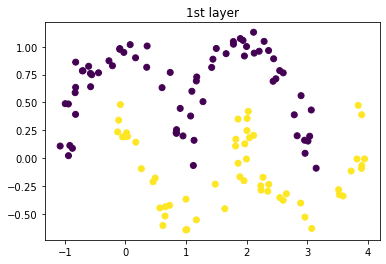

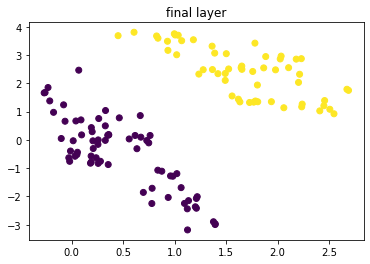

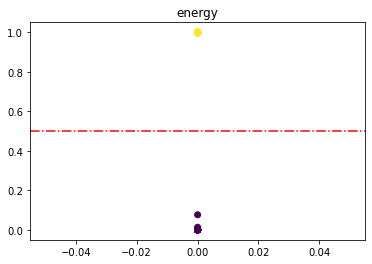

In [67]:
plt.scatter(local_samples.data.numpy()[:,0],local_samples.data.numpy()[:,1],c=local_labels)
plt.title('1st layer')
plt.show()

plt.scatter(YN.data.numpy()[:,0],YN.data.numpy()[:,1],c=local_labels)
plt.title('final layer')
plt.show()

plt.scatter(np.zeros(125),torch.sigmoid(compute_H(YN,K,b)).data.numpy(),c=local_labels)
plt.axhline(0.5, label='mean',linestyle='-.', color='r')
plt.title('energy')
plt.show()

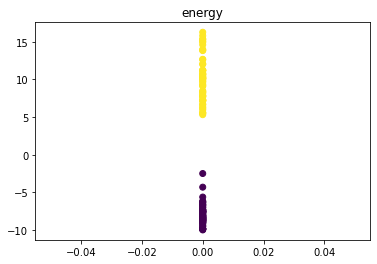

In [68]:
plt.scatter(np.zeros(125),compute_H(YN,K,b).data.numpy(),c=local_labels)
plt.title('energy')
plt.show()